In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =257

ng =4

nref =1

p_refs = (/ 50 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 4 /) 

data wgt
     &     /1 , 0.6 , 0.4 , 0.3/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.6 , 1.6 , 1.6 , 1.6/

klin =0

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

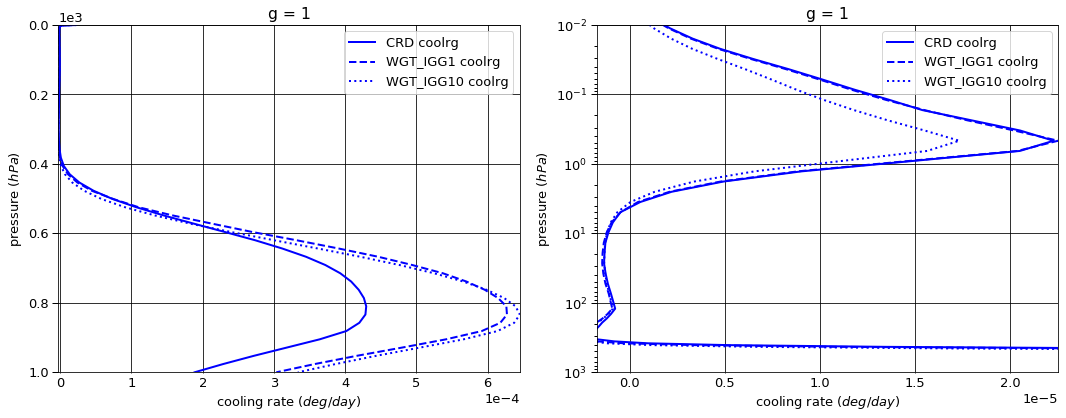

# Figure: cooling rate g-group 2

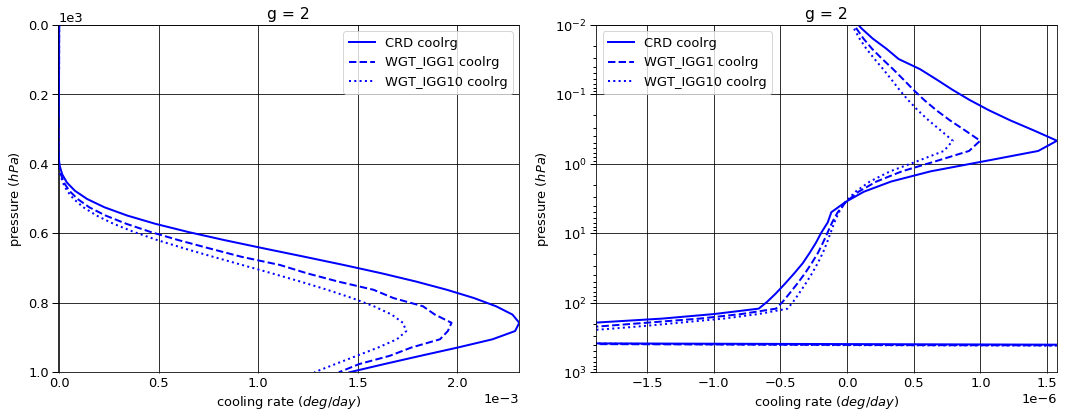

# Figure: cooling rate g-group 3

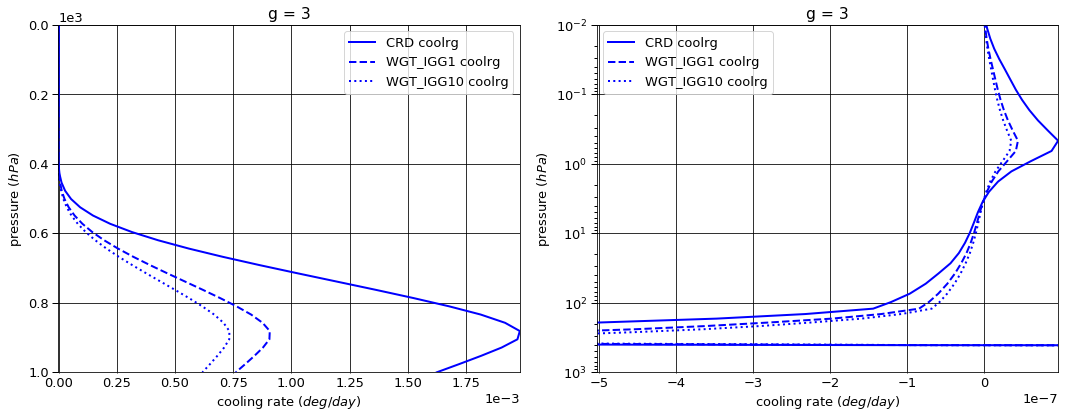

# Figure: cooling rate g-group 4

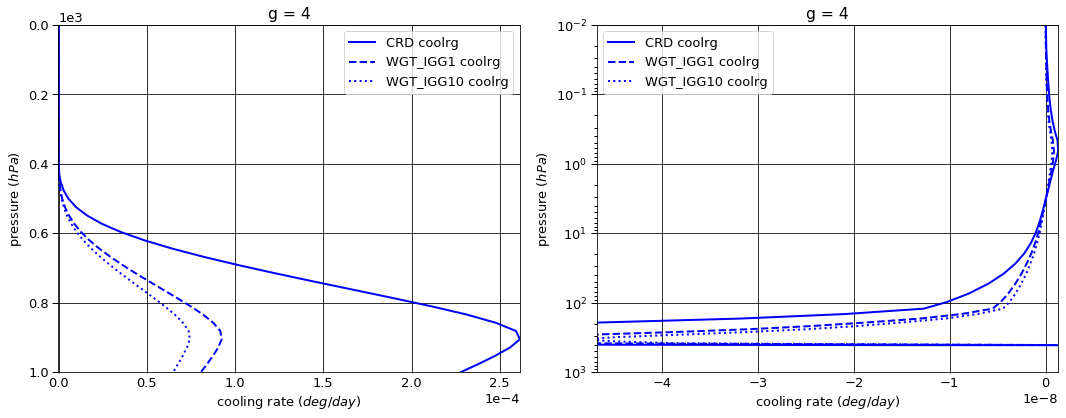

# Figure: cooling rate g-group total

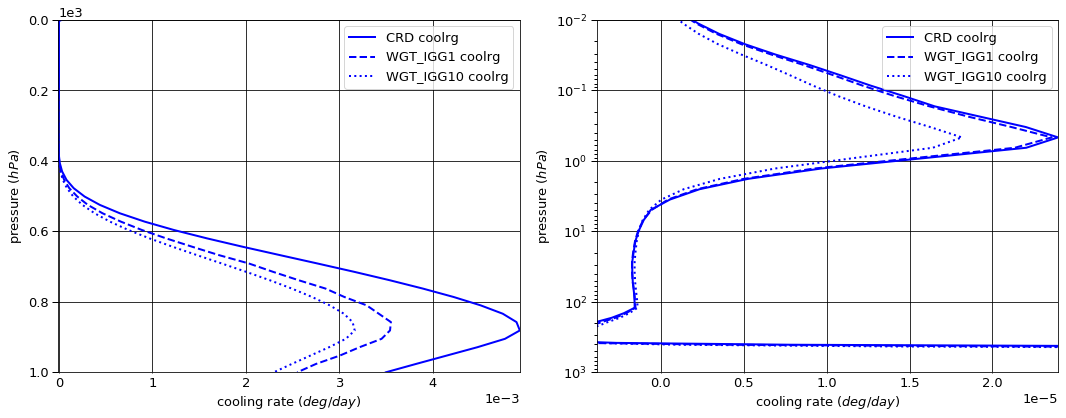

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.052086  0.000000 -0.052086
  1013.0   76    -0.054600  0.021728 -0.032872
2 0.0      1     -0.570608  0.000000 -0.570608
  1013.0   76    -0.576380  0.096135 -0.480245
3 0.0      1     -4.713516  0.000000 -4.713516
  1013.0   76    -4.715708  0.072458 -4.643250
4 0.0      1     -9.704500  0.000000 -9.704500
  1013.0   76    -9.704719  0.009219 -9.695500


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.051792  0.000000 -0.051792
  1013.0   76    -0.054600  0.029368 -0.025232
2 0.0      1     -0.572488  0.000000 -0.572488
  1013.0   76    -0.576380  0.078578 -0.497802
3 0.0      1     -4.714696  0.000000 -4.714696
  1013.0   76    -4.715708  0.033240 -4.682468
4 0.0      1     -9.704640  0.000000 -9.704640
  1013.0   76    -9.704719  0.003270 -9.701449


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.052167  0.000000 -0.052167
  1013.0   76    -0.054600  0.028864 -0.025736
2 0.0      1     -0.573267  0.000000 -0.573267
  1013.0   76    -0.576380  0.068394 -0.507986
3 0.0      1     -4.714896  0.000000 -4.714896
  1013.0   76    -4.715708  0.026859 -4.688849
4 0.0      1     -9.704655  0.000000 -9.704655
  1013.0   76    -9.704719  0.002630 -9.702089


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000294  0.000000  0.000294
  1013.0   76     0.000000  0.007640  0.007640
2 0.0      1     -0.001880  0.000000 -0.001880
  1013.0   76     0.000000 -0.017557 -0.017557
3 0.0      1     -0.001179  0.000000 -0.001179
  1013.0   76     0.000000 -0.039218 -0.039218
4 0.0      1     -0.000140  0.000000 -0.000140
  1013.0   76     0.000000 -0.005949 -0.005949


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000081  0.000000 -0.000081
  1013.0   76     0.000000  0.007136  0.007136
2 0.0      1     -0.002659  0.000000 -0.002659
  1013.0   76     0.000000 -0.027741 -0.027741
3 0.0      1     -0.001380  0.000000 -0.001380
  1013.0   76     0.000000 -0.045599 -0.045599
4 0.0      1     -0.000156  0.000000 -0.000156
  1013.0   76     0.000000 -0.006589 -0.006589

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.380899e-06
  1001.112500 75     1.886392e-04
2 0.000312    1     -1.703762e-07
  1001.112500 75     1.457867e-03
3 0.000312    1     -6.496410e-09
  1001.112500 75     1.624977e-03
4 0.000312    1     -2.401630e-11
  1001.112500 75     2.277389e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.386627e-06
  1001.112500 75     3.033643e-04
2 0.000312    1     -1.080568e-07
  1001.112500 75     1.405016e-03
3 0.000312    1     -3.002038e-09
  1001.112500 75     7.609372e-04
4 0.000312    1     -4.803261e-11
  1001.112500 75     8.057638e-05


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.272088e-06
  1001.112500 75     3.336939e-04
2 0.000312    1     -8.951477e-08
  1001.112500 75     1.282007e-03
3 0.000312    1     -2.353598e-09
  1001.112500 75     6.177912e-04
4 0.000312    1      2.401630e-11
  1001.112500 75     6.481455e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.727900e-09
  1001.112500 75     1.147252e-04
2 0.000312    1      6.231931e-08
  1001.112500 75    -5.285040e-05
3 0.000312    1      3.494372e-09
  1001.112500 75    -8.640400e-04
4 0.000312    1     -2.401630e-11
  1001.112500 75    -1.471625e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.088111e-07
  1001.112500 75     1.450547e-04
2 0.000312    1      8.086139e-08
  1001.112500 75    -1.758595e-04
3 0.000312    1      4.142812e-09
  1001.112500 75    -1.007186e-03
4 0.000312    1      4.803261e-11
  1001.112500 75    -1.629244e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.040711,0.000000,-15.040711
1013.0,76,-15.051406,0.199539,-14.851867



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.043616,0.000000,-15.043616
1013.0,76,-15.051406,0.144456,-14.906950



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.044985,0.000000,-15.044985
1013.0,76,-15.051406,0.126746,-14.924660



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.002905,0.000000,-0.002905
1013.0,76,0.000000,-0.055083,-0.055083



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.004275,0.000000,-0.004275
1013.0,76,0.000000,-0.072793,-0.072793


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.003499



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000001
1001.112500,75,0.002550



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000001
1001.112500,75,0.002298



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,6.006177e-08
1001.112500,75,-9.493277e-04



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,1.938633e-07
1001.112500,75,-1.200915e-03


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003750,0.003620
2,0.039167,0.038239
3,0.320417,0.312903
4,0.636667,0.645238


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.458881e-23
2,4.092653e-25
3,6.811963e-27
4,1.133809e-28


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.458881e-23,NaN,0.003750,0.003620,0.003750,0.003620,50.0
2,4.092653e-25,0.016644,0.039167,0.038239,0.042917,0.041859,50.0
3,6.811963e-27,0.016644,0.320417,0.312903,0.363333,0.354762,50.0
4,1.133809e-28,0.016644,0.636667,0.645238,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.189572e-23  7.874949e-24   4.050276  2.716276e-09
      2 0.000312     3.091883e-25  2.311424e-26  13.376529  1.658587e-11
      3 0.000312     1.338786e-27  1.590683e-28   8.416420  5.373288e-14
      4 0.000312     2.502294e-30  4.538585e-31   5.513379  9.098525e-17
2     1 0.000750     3.358145e-23  8.051854e-24   4.170648  1.151903e-09
      2 0.000750     3.204121e-25  2.360555e-26  13.573593  6.918307e-12
      3 0.000750     1.403809e-27  1.630537e-28   8.609487  2.261707e-14
      4 0.000750     2.671819e-30  4.784034e-31   5.584867  3.898151e-17
3     1 0.001052     3.723402e-23  8.404294e-24   4.430356  1.791117e-09
      2 0.001052     3.444483e-25  2.461934e-26  13.990963  1.041539e-11
      3 0.001052     1.545803e-27  1.709853e-28   9.040563  3.467899e-14
      4 0.001052     3.046208e-30  5.238999e-31   5.814485  6.160202e-17
4     1 0.001476     4.129485e-23  8.753240e-24   4.717664  2.786789e-09
      2 0.001476     3.708053e-25  2.569613e-26  14.430394  1.570796e-11
      3 0.001476     1.706066e-27  1.791398e-28   9.523658  5.330722e-14
      4 0.001476     3.488102e-30  5.758172e-31   6.057655  9.781992e-17
5     1 0.002070     4.575060e-23  9.092313e-24   5.031789  4.330468e-09
      2 0.002070     3.993841e-25  2.682588e-26  14.888014  2.369760e-11
      3 0.002070     1.885188e-27  1.874272e-28  10.058240  8.202049e-14
      4 0.002070     4.005756e-30  6.351382e-31   6.306904  1.558308e-16
6     1 0.002904     5.063383e-23  9.420364e-24   5.374934  6.722879e-09
      2 0.002904     4.303971e-25  2.800902e-26  15.366374  3.577500e-11
      3 0.002904     2.085830e-27  1.958776e-28  10.648640  1.263825e-13
      4 0.002904     4.614753e-30  7.040552e-31   6.554534  2.492528e-16
7     1 0.004074     5.597935e-23  9.737105e-24   5.749075  1.042629e-08
      2 0.004074     4.640812e-25  2.924407e-26  15.869240  5.404048e-11
      3 0.004074     2.311113e-27  2.045631e-28  11.297801  1.950404e-13
      4 0.004074     5.334575e-30  7.859225e-31   6.787661  4.005394e-16
8     1 0.005714     6.182526e-23  1.004314e-23   6.155967  1.615201e-08
      2 0.005714     5.007063e-25  3.052880e-26  16.401113  8.167681e-11
      3 0.005714     2.564744e-27  2.136252e-28  12.005814  3.015046e-13
      4 0.005714     6.189931e-30  8.859267e-31   6.986956  6.471563e-16
9     1 0.008015     6.821067e-23  1.033976e-23   6.596933  2.499669e-08
      2 0.008015     5.405646e-25  3.186235e-26  16.965623  1.235287e-10
      3 0.008015     2.851028e-27  2.232966e-28  12.767895  4.670164e-13
      4 0.008015     7.212081e-30  1.012000e-30   7.126563  1.052490e-15
10    1 0.011243     7.517902e-23  1.062894e-23   7.073051  3.864469e-08
      2 0.011243     5.839945e-25  3.325022e-26  17.563630  1.869531e-10
      3 0.011243     3.175140e-27  2.339305e-28  13.573007  7.250032e-13
      4 0.011243     8.441611e-30  1.176220e-30   7.176899  1.725020e-15
11    1 0.015771     8.277539e-23  1.091317e-23   7.584906  5.968491e-08
      2 0.015771     6.313696e-25  3.470963e-26  18.190043  2.831590e-10
      3 0.015771     3.543178e-27  2.460331e-28  14.401223  1.128359e-12
      4 0.015771     9.931291e-30  1.396896e-30   7.109542  2.853336e-15
12    1 0.022122     9.104773e-23  1.119549e-23   8.132536  9.208733e-08
      2 0.022122     6.831124e-25  3.627691e-26  18.830500  4.292238e-10
      3 0.022122     3.962423e-27  2.603316e-28  15.220676  1.761049e-12
      4 0.022122     1.175089e-29  1.701990e-30   6.904205  4.770515e-15
13    1 0.031031     1.000056e-22  1.147840e-23   8.712507  1.418809e-07
      2 0.031031     7.394442e-25  3.801038e-26  19.453740  6.510134e-10
      3 0.031031     4.439396e-27  2.778408e-28  15.978197  2.755829e-12
      4 0.031031     1.398447e-29  2.133701e-30   6.554092  8.071056e-15
14    1 0.043528     1.085695e-22  1.173701e-23   9.250182  2.160601e-07
      2 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
